# Обработка пропусков в данных, кодирование категориальных признаков, масштабирование данных.

### В чем состоит проблема?

- Если в данных есть пропуски, то большинство алгоритмов машинного обучения не будут с ними работать. Даже корреляционная матрица не будет строиться корректно.
- Большинство алгоритмов машинного обучения требуют явного перекодирования категориальных признаков в числовые. Даже если алгоритм не требует этого явно, такое перекодирование возможно стоит попробовать, чтобы повысить качество модели.
- Большинство алгоритмов показывает лучшее качество на масштабированных признаках, в особенности алгоритмы, использующие методы градиентного спуска.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

## Загрузка и первичный анализ данных


In [8]:
# Будем использовать только обучающую выборку
data = pd.read_csv('melb_data.csv', sep=",")

In [17]:
# размер набора данных
data.shape

(13580, 21)

In [16]:
# типы колонок
data.dtypes

Suburb            object
Address           object
Rooms              int64
Type              object
Price            float64
Method            object
SellerG           object
Date              object
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
CouncilArea       object
Lattitude        float64
Longtitude       float64
Regionname        object
Propertycount    float64
dtype: object

In [15]:
# проверим есть ли пропущенные значения
data.isnull().sum()

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                62
Landsize            0
BuildingArea     6450
YearBuilt        5375
CouncilArea      1369
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

In [23]:
data.nunique()

Suburb             314
Address          13378
Rooms                9
Type                 3
Price             2204
Method               5
SellerG            268
Date                58
Distance           202
Postcode           198
Bedroom2            12
Bathroom             9
Car                 11
Landsize          1448
BuildingArea       602
YearBuilt          144
CouncilArea         33
Lattitude         6503
Longtitude        7063
Regionname           8
Propertycount      311
dtype: int64

In [31]:
data['Car'].unique()

array([ 1.,  0.,  2.,  6.,  5.,  4.,  3.,  8.,  7.,  9., 10., nan])

In [32]:
data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [33]:
total_count = data.shape[0]
print('Всего строк: {}'.format(total_count))

Всего строк: 13580


# Обработка пропусков в данных

## Простые стратегии - удаление или заполнение нулями


In [34]:
# Удаление колонок, содержащих пустые значения
data_new_1 = data.dropna(axis=1, how='any')
(data.shape, data_new_1.shape)

((13580, 21), (13580, 17))

Удаление 4 столбцов из 21 может быть целесообразным

In [35]:
# Удаление строк, содержащих пустые значения
data_new_2 = data.dropna(axis=0, how='any')
(data.shape, data_new_2.shape)

((13580, 21), (6196, 21))

Удаление половины строк целесообразным быть не может

## "Внедрение значений" - импьютация (imputation)

In [36]:
data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


### Обработка пропусков в числовых данных

In [42]:
# Выберем числовые колонки с пропущенными значениями
# Цикл по колонкам датасета
num_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='float64' or dt=='int64'):
        num_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка Car. Тип данных float64. Количество пустых значений 62, 0.46%.
Колонка BuildingArea. Тип данных float64. Количество пустых значений 6450, 47.5%.
Колонка YearBuilt. Тип данных float64. Количество пустых значений 5375, 39.58%.


Из этого можно сделать вывод, что вторую и третью колонки будет целесообразнее отбросить, а с первой колонкой можно поработать на предмет заполнения пустых значений

In [43]:
# Фильтр по колонкам с пропущенными значениями
data_num = data[num_cols]
data_num

,Car,BuildingArea,YearBuilt
0,1.0,NaN,NaN
1,0.0,79.0,1900.0
2,0.0,150.0,1900.0
3,1.0,NaN,NaN
4,2.0,142.0,2014.0
...,...,...,...
13575,2.0,NaN,1981.0
13576,2.0,133.0,1995.0
13577,4.0,NaN,1997.0
13578,5.0,157.0,1920.0


In [44]:
data['Car'].unique()

array([ 1.,  0.,  2.,  6.,  5.,  4.,  3.,  8.,  7.,  9., 10., nan])

In [49]:
data['BuildingArea'].max()

44515.0

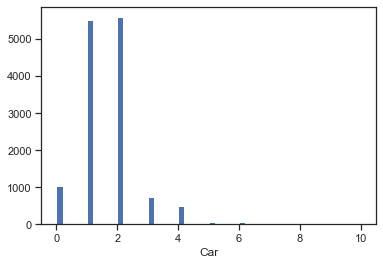

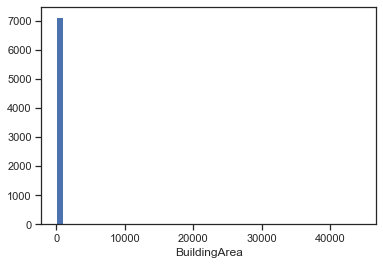

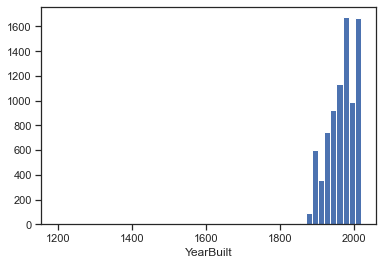

In [45]:
# Гистограмма по признакам
for col in data_num:
    plt.hist(data[col], 50)
    plt.xlabel(col)
    plt.show()

Будем использовать встроенные средства импьютации библиотеки scikit-learn - https://scikit-learn.org/stable/modules/impute.html

Как было описано ранее, работать мы будем с колонкой "Car", так как она имеет допустимо небольшое количество пропусков
По диаграмме выше вы видим, что признак имеет практически нормальное распределение, так что наиболее приемлимый вариант - подставлять значение по медиане

In [61]:
data_num_Car = data_num[['Car']]
data_num_Car.head()

,Car
0,1.0
1,0.0
2,0.0
3,1.0
4,2.0


In [63]:
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator

In [64]:
indicator = MissingIndicator()
mask_filter = indicator.fit_transform(data_num_Car)
mask_filter

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [67]:
imputer = SimpleImputer(strategy = 'median')
imp_Car = imputer.fit_transform(data_num_Car)
imp_Car[mask_filter]

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

### Обработка пропусков в категориальных данных

In [68]:
# Выберем категориальные колонки с пропущенными значениями
# Цикл по колонкам датасета
cat_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='object'):
        cat_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка CouncilArea. Тип данных object. Количество пустых значений 1369, 10.08%.


In [70]:
data["CouncilArea"].unique()

array(['Yarra', 'Moonee Valley', 'Port Phillip', 'Darebin', 'Hobsons Bay',
       'Stonnington', 'Boroondara', 'Monash', 'Glen Eira', 'Whitehorse',
       'Maribyrnong', 'Bayside', 'Moreland', 'Manningham', 'Banyule',
       'Melbourne', 'Kingston', 'Brimbank', 'Hume', nan, 'Knox',
       'Maroondah', 'Casey', 'Melton', 'Greater Dandenong', 'Nillumbik',
       'Whittlesea', 'Frankston', 'Macedon Ranges', 'Yarra Ranges',
       'Wyndham', 'Cardinia', 'Unavailable', 'Moorabool'], dtype=object)

<AxesSubplot:>

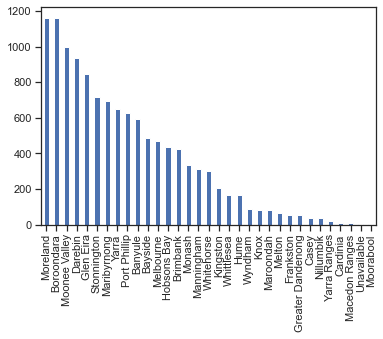

In [81]:
data["CouncilArea"].value_counts().plot.bar()

Класс SimpleImputer можно использовать для категориальных признаков со стратегиями "most_frequent" или "constant".

In [91]:
cat_temp_data = data[['CouncilArea']]

In [93]:
cat_temp_data[data['CouncilArea'].isnull()].shape

(1369, 1)

In [95]:
imp = SimpleImputer(strategy = 'constant', fill_value = 'NA')
area_imp = imp.fit_transform(cat_temp_data)
area_imp

array([['Yarra'],
       ['Yarra'],
       ['Yarra'],
       ...,
       ['NA'],
       ['NA'],
       ['NA']], dtype=object)

In [99]:
np.unique(area_imp)

array(['Banyule', 'Bayside', 'Boroondara', 'Brimbank', 'Cardinia',
       'Casey', 'Darebin', 'Frankston', 'Glen Eira', 'Greater Dandenong',
       'Hobsons Bay', 'Hume', 'Kingston', 'Knox', 'Macedon Ranges',
       'Manningham', 'Maribyrnong', 'Maroondah', 'Melbourne', 'Melton',
       'Monash', 'Moonee Valley', 'Moorabool', 'Moreland', 'NA',
       'Nillumbik', 'Port Phillip', 'Stonnington', 'Unavailable',
       'Whitehorse', 'Whittlesea', 'Wyndham', 'Yarra', 'Yarra Ranges'],
      dtype=object)

# Преобразование категориальных признаков в числовые

In [97]:
cat_enc = pd.DataFrame({'c1':area_imp.T[0]})
cat_enc

,c1
0,Yarra
1,Yarra
2,Yarra
3,Yarra
4,Yarra
...,...
13575,NA
13576,NA
13577,NA
13578,NA


Поскольку создание 34 новых колонок крайне нецелесообразно, попробуем закодировать наш признак числовыми значениями, не используя ONE HOT. 

## Кодирование категорий целочисленными значениями (label encoding)

In [103]:
from sklearn.preprocessing import LabelEncoder

In [101]:
cat_enc['c1'].unique()

array(['Yarra', 'Moonee Valley', 'Port Phillip', 'Darebin', 'Hobsons Bay',
       'Stonnington', 'Boroondara', 'Monash', 'Glen Eira', 'Whitehorse',
       'Maribyrnong', 'Bayside', 'Moreland', 'Manningham', 'Banyule',
       'Melbourne', 'Kingston', 'Brimbank', 'Hume', 'NA', 'Knox',
       'Maroondah', 'Casey', 'Melton', 'Greater Dandenong', 'Nillumbik',
       'Whittlesea', 'Frankston', 'Macedon Ranges', 'Yarra Ranges',
       'Wyndham', 'Cardinia', 'Unavailable', 'Moorabool'], dtype=object)

In [104]:
le = LabelEncoder()
cat_enc_le = le.fit_transform(cat_enc['c1'])

In [105]:
# Наименования категорий в соответствии с порядковыми номерами

# Свойство называется classes, потому что предполагается что мы решаем 
# задачу классификации и каждое значение категории соответствует 
# какому-либо классу целевого признака

le.classes_

array(['Banyule', 'Bayside', 'Boroondara', 'Brimbank', 'Cardinia',
       'Casey', 'Darebin', 'Frankston', 'Glen Eira', 'Greater Dandenong',
       'Hobsons Bay', 'Hume', 'Kingston', 'Knox', 'Macedon Ranges',
       'Manningham', 'Maribyrnong', 'Maroondah', 'Melbourne', 'Melton',
       'Monash', 'Moonee Valley', 'Moorabool', 'Moreland', 'NA',
       'Nillumbik', 'Port Phillip', 'Stonnington', 'Unavailable',
       'Whitehorse', 'Whittlesea', 'Wyndham', 'Yarra', 'Yarra Ranges'],
      dtype=object)

In [106]:
cat_enc_le

array([32, 32, 32, ..., 24, 24, 24])

In [107]:
cat_enc['c1'] = cat_enc_le
cat_enc

,c1
0,32
1,32
2,32
3,32
4,32
...,...
13575,24
13576,24
13577,24
13578,24


In [108]:
np.unique(cat_enc_le)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

# Масштабирование данных

Термины "масштабирование" и "нормализация" часто используются как синонимы, но это неверно. Масштабирование предполагает изменение диапазона измерения величины, а нормализация - изменение распределения этой величины. В этом разделе рассматривается только масштабирование.

Если признаки лежат в различных диапазонах, то необходимо их нормализовать. Как правило, применяют два подхода:
- MinMax масштабирование:
$$ x_{новый} = \frac{x_{старый} - min(X)}{max(X)-min(X)} $$

В этом случае значения лежат в диапазоне от 0 до 1.
- Масштабирование данных на основе [Z-оценки](https://ru.wikipedia.org/wiki/Z-%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B0):
$$ x_{новый} = \frac{x_{старый} - AVG(X) }{\sigma(X)} $$

В этом случае большинство значений попадает в диапазон от -3 до 3.

где $X$ - матрица объект-признак, $AVG(X)$ - среднее значение, $\sigma$ - среднеквадратичное отклонение.

In [110]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

In [111]:
data.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,13580.000000,1.358000e+04,13580.000000,13580.000000,13580.000000,13580.000000,13518.000000,13580.000000,7130.000000,8205.000000,13580.000000,13580.000000,13580.000000
mean,2.937997,1.075684e+06,10.137776,3105.301915,2.914728,1.534242,1.610075,558.416127,151.967650,1964.684217,-37.809203,144.995216,7454.417378
std,0.955748,6.393107e+05,5.868725,90.676964,0.965921,0.691712,0.962634,3990.669241,541.014538,37.273762,0.079260,0.103916,4378.581772
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1196.000000,-38.182550,144.431810,249.000000
25%,2.000000,6.500000e+05,6.100000,3044.000000,2.000000,1.000000,1.000000,177.000000,93.000000,1940.000000,-37.856822,144.929600,4380.000000
50%,3.000000,9.030000e+05,9.200000,3084.000000,3.000000,1.000000,2.000000,440.000000,126.000000,1970.000000,-37.802355,145.000100,6555.000000
75%,3.000000,1.330000e+06,13.000000,3148.000000,3.000000,2.000000,2.000000,651.000000,174.000000,1999.000000,-37.756400,145.058305,10331.000000
max,10.000000,9.000000e+06,48.100000,3977.000000,20.000000,8.000000,10.000000,433014.000000,44515.000000,2018.000000,-37.408530,145.526350,21650.000000


## [MinMax масштабирование](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [116]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data[['Propertycount']])

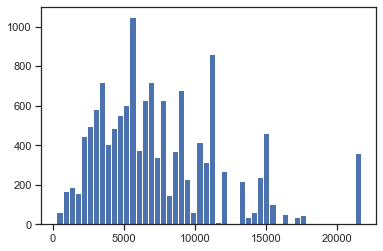

In [117]:
plt.hist(data['Propertycount'], 50)
plt.show()

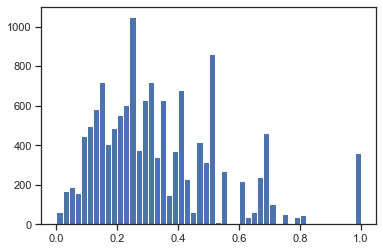

In [118]:
plt.hist(sc1_data, 50)
plt.show()